# Convolutional Neural Network

### CNN

CNN v.s DNN: add spatial information

##### Convolution Kernel

Convolution kernel (filter): its channel must be the same as the input channel, and the output channel is the number of filters 

<div style="text-align: center">
    <img src="./Asset/p3.png" width="500" height="200">
</div>

In [ ]:
import torch
in_channels, out_channels = 5, 10
width, height = 100, 100
# kernel: 5*3*3, kernel size could be (4,3)
kernel_size = 3
batch_size = 1

# Input must be mini-batch in pytorch, so add one dimension
input = torch.randn(batch_size,
                    in_channels,
                    width,
                    height)

conv_layer = torch.nn.Conv2d(in_channels,
                                out_channels,
                                kernel_size=kernel_size)

output = conv_layer(input)

print(input.shape)
print(output.shape)
print(conv_layer.weight.shape)

torch.Size([1, 5, 100, 100])
torch.Size([1, 10, 98, 98])
torch.Size([10, 5, 3, 3])


##### Padding

Padding: add 0 to the edge of the input, so that the output size is the same as the input size

Padding size = $\frac{kernel\_size - 1}{2}$

In [ ]:
input = [3,4,6,5,7,
         2,4,6,8,2,
         1,6,7,8,4,
         9,7,4,6,2,
         3,7,5,4,1]
# view(1,1,5,5) = B*C*H*W
input = torch.Tensor(input).view(1,1,5,5)

conv_layer = torch.nn.Conv2d(1,1,kernel_size=3, padding=1, bias=False)

kernel = torch.Tensor([1,2,3,4,5,6,7,8,9]).view(1,1,3,3)
conv_layer.weight.data = kernel.data

output = conv_layer(input)
print(output)

tensor([[[[ 91., 168., 224., 215., 127.],
          [114., 211., 295., 262., 149.],
          [192., 259., 282., 214., 122.],
          [194., 251., 253., 169.,  86.],
          [ 96., 112., 110.,  68.,  31.]]]], grad_fn=<ConvolutionBackward0>)


##### Stride

In [ ]:
input = [3,4,6,5,7,
         2,4,6,8,2,
         1,6,7,8,4,
         9,7,4,6,2,
         3,7,5,4,1]
# view(1,1,5,5) = B*C*H*W
input = torch.Tensor(input).view(1,1,5,5)

conv_layer = torch.nn.Conv2d(1,1,kernel_size=3, stride = 2, bias=False)

kernel = torch.Tensor([1,2,3,4,5,6,7,8,9]).view(1,1,3,3)
conv_layer.weight.data = kernel.data

output = conv_layer(input)
print(output)

tensor([[[[211., 262.],
          [251., 169.]]]], grad_fn=<ConvolutionBackward0>)


##### Max Pooling

In [ ]:
input = [3,4,6,5,
         2,4,6,8,
         1,6,7,8,
         9,7,4,6]
input = torch.Tensor(input).view(1,1,4,4)

max_pooling_layer = torch.nn.MaxPool2d(kernel_size=2)

output = max_pooling_layer(input)
print(output)

tensor([[[[4., 8.],
          [9., 8.]]]])


#### Simple CNN

##### 1. Prepare Dataset

In [ ]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
batch_size = 64

transform = transforms.Compose([
    # Transfer PIL image to tensor: c*h*w, value in [0,1]
    transforms.ToTensor(),
    # Normalize parameters are mean and std of MNIST dataset
    transforms.Normalize((0.1307,), (0.3081,))
])

# datasets.MNIST() includes getitem() and len()
train_dataset = datasets.MNIST(root='./mnist_data/',
                                 train=True,
                                 download=True,
                                 transform=transform)
train_loader = DataLoader(dataset=train_dataset,
                            batch_size=batch_size,
                            shuffle=True)

test_dataset = datasets.MNIST(root='./mnist_data/',
                                train=False,
                                download=True,
                                transform=transform)

test_loader = DataLoader(dataset=test_dataset,
                            batch_size=batch_size,
                            shuffle=False)

##### 2. Design Model

<div style="text-align: center">
    <img src="./Asset/p4.png" width="350" height="400">
</div>

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = torch.nn.Conv2d(1,10,kernel_size=5)
        self.conv2 = torch.nn.Conv2d(10,20,kernel_size=5)
        self.max_pooling = torch.nn.MaxPool2d(2)
        self.activate = torch.nn.ReLU()
        self.fc = torch.nn.Linear(320,10)

    def forward(self, x):
        # input dim: batch*c*h*w
        batch_size = x.size(0)
        # view() is reshape, -1 means infer from other dimensions
        x = self.max_pooling(self.activate(self.conv1(x)))
        x = self.max_pooling(self.activate(self.conv2(x)))
        # Last layer: flatten data and no activation fn
        x = x.view(batch_size, -1) # flatten
        return self.fc(x)
    
model = Model()

##### 3. Construct Loss and Optimizer

In [ ]:
criterion =  torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

##### 4. Training and Testing

In [ ]:
def train(epoch):
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, traget = data
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, traget)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if batch_idx % 300 == 299:
            print('[%d, %5d] loss: %.3f' % (epoch+1, batch_idx+1, running_loss/300))
            running_loss = 0.0

def test():
    correct = 0
    total = 0
    # no_grad() to avoid gradient calculation
    with torch.no_grad():
        for data in test_loader:
            inputs, traget = data
            outputs = model(inputs)
            # torch.max() return (max_value, index), dim=1 means max in each row
            _, predicted = torch.max(outputs.data, dim=1)
            total += traget.size(0)
            correct += (predicted == traget).sum().item()
    print('Accuracy on test set: %d %%' % (100*correct/total))
    return 100*correct/total

In [ ]:
if __name__ == '__main__':
    accuracy_list = []
    for epoch in range(10):
        train(epoch)
        accuracy = test()
        accuracy_list.append(accuracy)

[1,   300] loss: 0.525
[1,   600] loss: 0.183
[1,   900] loss: 0.124
Accuracy on test set: 97 %
[2,   300] loss: 0.103
[2,   600] loss: 0.098
[2,   900] loss: 0.088
Accuracy on test set: 97 %
[3,   300] loss: 0.078
[3,   600] loss: 0.069
[3,   900] loss: 0.069
Accuracy on test set: 97 %
[4,   300] loss: 0.065
[4,   600] loss: 0.059
[4,   900] loss: 0.056
Accuracy on test set: 98 %
[5,   300] loss: 0.055
[5,   600] loss: 0.053
[5,   900] loss: 0.052
Accuracy on test set: 98 %
[6,   300] loss: 0.051
[6,   600] loss: 0.046
[6,   900] loss: 0.045
Accuracy on test set: 98 %
[7,   300] loss: 0.042
[7,   600] loss: 0.045
[7,   900] loss: 0.043
Accuracy on test set: 98 %
[8,   300] loss: 0.040
[8,   600] loss: 0.040
[8,   900] loss: 0.039
Accuracy on test set: 98 %
[9,   300] loss: 0.035
[9,   600] loss: 0.037
[9,   900] loss: 0.040
Accuracy on test set: 98 %
[10,   300] loss: 0.037
[10,   600] loss: 0.034
[10,   900] loss: 0.032
Accuracy on test set: 98 %


Text(0.5, 0, 'Epoch')

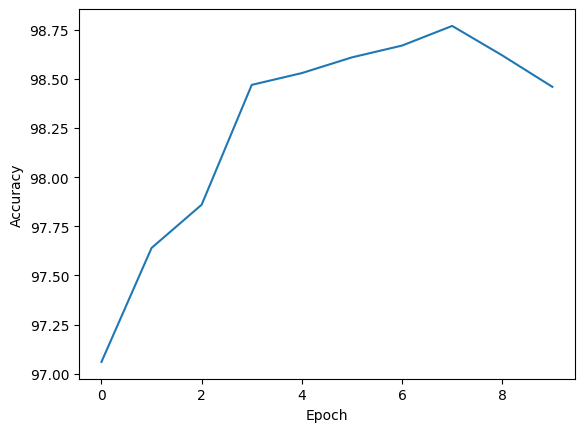

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(10), accuracy_list)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

##### Exercise: More complex CNN

<div style="text-align: center">
    <img src="./Asset/p5.png" width="350" height="400">
</div>

In [ ]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1,10,kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(10,20,kernel_size=3)
        self.conv3 = torch.nn.Conv2d(20,40,kernel_size=3, padding=1)
        self.max_pooling = torch.nn.MaxPool2d(2)
        self.activate = torch.nn.ReLU()
        self.fc = torch.nn.Linear(360,256)
        self.fc2 = torch.nn.Linear(256,10)

    def forward(self, x):
        # input dim: batch*c*h*w
        batch_size = x.size(0)
        x = self.max_pooling(self.activate(self.conv1(x)))
        x = self.max_pooling(self.activate(self.conv2(x)))
        x = self.max_pooling(self.activate(self.conv3(x)))
        # Last layer: flatten data and no activation fn
        x = x.view(batch_size, -1) # flatten
        x = self.fc(x)
        x = self.fc2(x)
        return x
    
model = CNN()

Need to reset criterion and optimizer and train the model again.

In [ ]:
criterion =  torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [ ]:
def train(epoch):
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, traget = data
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, traget)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if batch_idx % 300 == 299:
            print('[%d, %5d] loss: %.3f' % (epoch+1, batch_idx+1, running_loss/300))
            running_loss = 0.0

def test():
    correct = 0
    total = 0
    # no_grad() to avoid gradient calculation
    with torch.no_grad():
        for data in test_loader:
            inputs, traget = data
            outputs = model(inputs)
            # torch.max() return (max_value, index), dim=1 means max in each row
            _, predicted = torch.max(outputs.data, dim=1)
            total += traget.size(0)
            correct += (predicted == traget).sum().item()
    print('Accuracy on test set: %d %%' % (100*correct/total))
    return 100*correct/total

In [ ]:
if __name__ == '__main__':
    accuracy_list = []
    for epoch in range(10):
        train(epoch)
        accuracy = test()
        accuracy_list.append(accuracy)

[1,   300] loss: 1.224
[1,   600] loss: 0.245
[1,   900] loss: 0.156
Accuracy on test set: 96 %
[2,   300] loss: 0.121
[2,   600] loss: 0.104
[2,   900] loss: 0.095
Accuracy on test set: 96 %
[3,   300] loss: 0.080
[3,   600] loss: 0.081
[3,   900] loss: 0.072
Accuracy on test set: 98 %
[4,   300] loss: 0.064
[4,   600] loss: 0.065
[4,   900] loss: 0.061
Accuracy on test set: 98 %
[5,   300] loss: 0.058
[5,   600] loss: 0.052
[5,   900] loss: 0.054
Accuracy on test set: 98 %
[6,   300] loss: 0.049
[6,   600] loss: 0.047
[6,   900] loss: 0.048
Accuracy on test set: 98 %
[7,   300] loss: 0.044
[7,   600] loss: 0.042
[7,   900] loss: 0.046
Accuracy on test set: 98 %
[8,   300] loss: 0.039
[8,   600] loss: 0.041
[8,   900] loss: 0.040
Accuracy on test set: 98 %
[9,   300] loss: 0.036
[9,   600] loss: 0.035
[9,   900] loss: 0.038
Accuracy on test set: 98 %
[10,   300] loss: 0.036
[10,   600] loss: 0.034
[10,   900] loss: 0.031
Accuracy on test set: 98 %


Text(0.5, 0, 'Epoch')

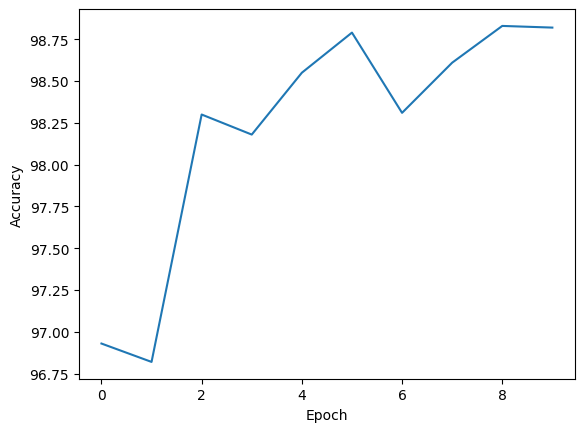

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(10), accuracy_list)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

### Advanced CNN

#### GoogLeNet
##### Inception Module

Why: Provide a way to use different filter size in one layer, and train to select the best filter size

<div style="text-align: center">
    <img src="./Asset/p6.png" width="400" height="350">
</div>

How to ensure each conv layer has the same output size: by padding and stride = 1

Why $1\times 1$ conv: reduce the number of channels, and reduce the computation

In [ ]:
import torch.nn as nn

class Inception(nn.Module):
    def __init__(self, in_channels):
        super(Inception, self).__init__()
        self.avg_pooling = torch.nn.AvgPool2d(kernel_size=3, stride=1, padding=1)
        self.brach_pool = torch.nn.Conv2d(in_channels,24,kernel_size=1)
        
        self.branch1x1 = torch.nn.Conv2d(in_channels,16,kernel_size=1)
        
        self.branch5x5_1 = torch.nn.Conv2d(in_channels,16,kernel_size=1)
        self.branch5x5_2 = torch.nn.Conv2d(16,24,kernel_size=5, padding=2)

        self.branch3x3_1 = torch.nn.Conv2d(in_channels,16,kernel_size=1)
        self.branch3x3_2 = torch.nn.Conv2d(16,24,kernel_size=3, padding=1)
        self.branch3x3_3 = torch.nn.Conv2d(24,24,kernel_size=3, padding=1)

    def forward(self, x):
        branch_pool = self.avg_pooling(x)
        branch_pool = self.brach_pool(branch_pool)

        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)
        branch3x3 = self.branch3x3_3(branch3x3)

        # Concatenate on the channel dimension (b*c*h*w, dim=1 means c)
        outputs = [branch_pool, branch1x1, branch5x5, branch3x3]
        return torch.cat(outputs, dim=1)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1,10,kernel_size=5)
        self.conv2 = torch.nn.Conv2d(88,20,kernel_size=5)
        
        self.inception1 = Inception(in_channels=10)
        self.inception2 = Inception(in_channels=20)

        self.max_pooling = torch.nn.MaxPool2d(2)
        # When develop, remove following and using random input to get the output size
        self.fc = torch.nn.Linear(1408,10)
        self.active = torch.nn.ReLU()

    def forward(self, x):
        in_size = x.size(0)
        x = self.active(self.max_pooling(self.conv1(x)))
        x = self.inception1(x)
        # 88 = 24+16+24+24, output of inception1
        x = self.active(self.max_pooling(self.conv2(x)))
        x = self.inception2(x)
        x = x.view(in_size, -1)
        x = self.fc(x)
        return x

model = Net()

In [ ]:
criterion =  torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [ ]:
def train(epoch):
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, traget = data
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, traget)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if batch_idx % 300 == 299:
            print('[%d, %5d] loss: %.3f' % (epoch+1, batch_idx+1, running_loss/300))
            running_loss = 0.0

def test():
    correct = 0
    total = 0
    # no_grad() to avoid gradient calculation
    with torch.no_grad():
        for data in test_loader:
            inputs, traget = data
            outputs = model(inputs)
            # torch.max() return (max_value, index), dim=1 means max in each row
            _, predicted = torch.max(outputs.data, dim=1)
            total += traget.size(0)
            correct += (predicted == traget).sum().item()
    print('Accuracy on test set: %d %%' % (100*correct/total))
    return 100*correct/total

In [ ]:
if __name__ == '__main__':
    accuracy_list = []
    for epoch in range(10):
        train(epoch)
        accuracy = test()
        accuracy_list.append(accuracy)

[1,   300] loss: 0.888
[1,   600] loss: 0.218
[1,   900] loss: 0.147
Accuracy on test set: 96 %
[2,   300] loss: 0.116
[2,   600] loss: 0.099
[2,   900] loss: 0.083
Accuracy on test set: 97 %
[3,   300] loss: 0.084
[3,   600] loss: 0.070
[3,   900] loss: 0.070
Accuracy on test set: 98 %
[4,   300] loss: 0.063
[4,   600] loss: 0.063
[4,   900] loss: 0.063
Accuracy on test set: 98 %
[5,   300] loss: 0.055
[5,   600] loss: 0.057
[5,   900] loss: 0.054
Accuracy on test set: 98 %
[6,   300] loss: 0.047
[6,   600] loss: 0.053
[6,   900] loss: 0.047
Accuracy on test set: 98 %
[7,   300] loss: 0.043
[7,   600] loss: 0.049
[7,   900] loss: 0.042
Accuracy on test set: 98 %
[8,   300] loss: 0.040
[8,   600] loss: 0.043
[8,   900] loss: 0.040
Accuracy on test set: 98 %
[9,   300] loss: 0.038
[9,   600] loss: 0.037
[9,   900] loss: 0.040
Accuracy on test set: 98 %
[10,   300] loss: 0.034
[10,   600] loss: 0.037
[10,   900] loss: 0.035
Accuracy on test set: 98 %


Text(0.5, 0, 'Epoch')

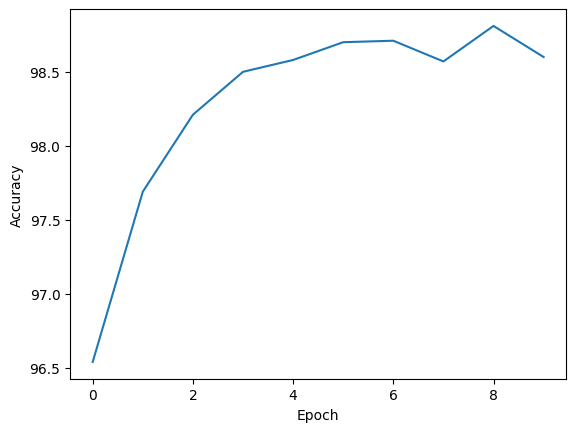

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(10), accuracy_list)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

#### ResNet

##### Residual Block

Why: solve the problem of vanishing gradient
How: add a shortcut connection
<div style="text-align: center">
    <img src="./Asset/p7.png" width="300" height="250">
</div>

$$\frac{\partial H(x)}{\partial x} = \frac{\partial F(x)}{\partial x} + 1$$

Input and output channel must be the same for residual block

In [ ]:
class ResidualBlock(nn.Module):
    # Given channels,force input and output of all conv layers have the same channels
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.channels = channels
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.active = nn.ReLU()

    def forward(self, x):
        # Residual block: x + conv2(conv1(x))
        y = self.active(self.conv1(x))
        y = self.conv2(y)
        return self.active(y + x)

<div style="text-align: center">
    <img src="./Asset/p8.png" width="400" height="350">
</div>

In [ ]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1,16,kernel_size=5)
        self.conv2 = torch.nn.Conv2d(16,32,kernel_size=5)
        self.active = torch.nn.ReLU()
        self.max_pooling = torch.nn.MaxPool2d(2)
        
        self.res1 = ResidualBlock(channels=16)
        self.res2 = ResidualBlock(channels=32)

        # When develop, remove following and using random input to get the output size
        self.fc = torch.nn.Linear(512,10)

    def forward(self, x):
        in_size = x.size(0)
        x = self.max_pooling(self.active(self.conv1(x)))
        x = self.res1(x)
        x = self.max_pooling(self.active(self.conv2(x)))
        x = self.res2(x)
        x = x.view(in_size, -1)
        x = self.fc(x)
        return x

model = ResNet()

In [ ]:
criterion =  torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [ ]:
def train(epoch):
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, traget = data
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, traget)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if batch_idx % 300 == 299:
            print('[%d, %5d] loss: %.3f' % (epoch+1, batch_idx+1, running_loss/300))
            running_loss = 0.0

def test():
    correct = 0
    total = 0
    # no_grad() to avoid gradient calculation
    with torch.no_grad():
        for data in test_loader:
            inputs, traget = data
            outputs = model(inputs)
            # torch.max() return (max_value, index), dim=1 means max in each row
            _, predicted = torch.max(outputs.data, dim=1)
            total += traget.size(0)
            correct += (predicted == traget).sum().item()
    print('Accuracy on test set: %d %%' % (100*correct/total))
    return 100*correct/total

In [ ]:
if __name__ == '__main__':
    accuracy_list = []
    for epoch in range(10):
        train(epoch)
        accuracy = test()
        accuracy_list.append(accuracy)

[1,   300] loss: 0.505
[1,   600] loss: 0.146
[1,   900] loss: 0.099
Accuracy on test set: 97 %
[2,   300] loss: 0.090
[2,   600] loss: 0.071
[2,   900] loss: 0.069
Accuracy on test set: 98 %
[3,   300] loss: 0.063
[3,   600] loss: 0.055
[3,   900] loss: 0.056
Accuracy on test set: 98 %
[4,   300] loss: 0.047
[4,   600] loss: 0.047
[4,   900] loss: 0.048
Accuracy on test set: 98 %
[5,   300] loss: 0.038
[5,   600] loss: 0.042
[5,   900] loss: 0.040
Accuracy on test set: 98 %
[6,   300] loss: 0.035
[6,   600] loss: 0.036
[6,   900] loss: 0.033
Accuracy on test set: 98 %
[7,   300] loss: 0.028
[7,   600] loss: 0.032
[7,   900] loss: 0.032
Accuracy on test set: 98 %
[8,   300] loss: 0.028
[8,   600] loss: 0.026
[8,   900] loss: 0.030
Accuracy on test set: 98 %
[9,   300] loss: 0.025
[9,   600] loss: 0.025
[9,   900] loss: 0.023
Accuracy on test set: 99 %
[10,   300] loss: 0.023
[10,   600] loss: 0.024
[10,   900] loss: 0.020
Accuracy on test set: 99 %


Text(0.5, 0, 'Epoch')

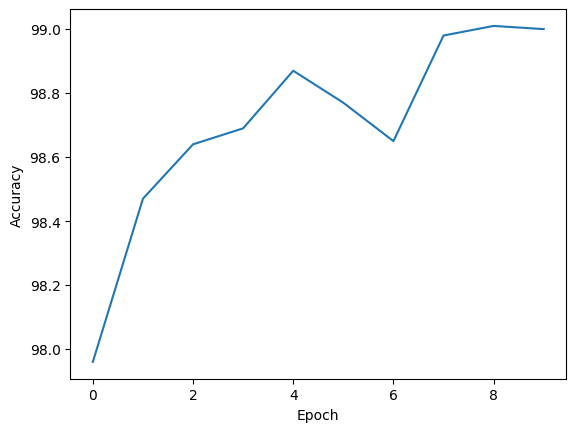

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(10), accuracy_list)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

##### Two variations of ResNet
<div style="text-align: center">
    <img src="./Asset/p9.png" width="500" height="200">
</div>

In [ ]:
# Constant Scaling
class Cons_scal_res_block(nn.Module):
    # Given channels,force input and output of all conv layers have the same channels
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.channels = channels
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.active = nn.ReLU()

    def forward(self, x):
        # Residual block: x + conv2(conv1(x))
        y = self.active(self.conv1(x))
        y = self.conv2(y)
        return self.active((y + x)*0.5)

In [ ]:
# Conv shortcut
class Conv_shortcut_res_block(nn.Module):
    # Given channels,force input and output of all conv layers have the same channels
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.channels = channels
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv_shortcut = nn.Conv2d(channels, channels, kernel_size=1)
        self.active = nn.ReLU()

    def forward(self, x):
        # Residual block: x + conv2(conv1(x))
        y = self.active(self.conv1(x))
        y = self.conv2(y)
        return self.active(y + self.conv_shortcut(x))